# IAAIP 2022 - Synthetic Data Generation using Variational Autoencoders
*Lecturer: Simon H. Tindemans*

*Assistant: Kutay Bölat*

This notebook is dedicated to give a better understanding what has been lectured in TU Delft IAAIP 2022 - Synthetic Data Generation using Variational Autoencoders (VAEs) tutorial. It allows users of it to play with different configurations and observe the visualized results. 

The [GitHub repository of the notebook](https://github.com/kabolat/IAAIP_tutorial) will be functioning. If you experience any issues or contribute to the code, feel free to open an Issue or request a Push.

## Import Libraries

This notebook mainly utilizes PyTorch. The rest of the libraries are mostly for visualization and data preperation purposes.

In [54]:
%matplotlib inline

import torch
import matplotlib.pyplot as plt
import matplotlib
import requests
import os
import zipfile
import pandas as pd
from tqdm.notebook import tqdm
from numpy import isnan
from datetime import timedelta, datetime
from torch.utils.tensorboard import SummaryWriter

## Download Data

The dataset chosen for this demonstration is [Individual Household Electric Power Consumption Dataset](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption) from UCI code repository. It contains a smart meter data with a sampling period of 1 minute. Further description can be found on the website.

Following code basically downloads the dataset and converts it to CSV format (if you have not done it already).

In [55]:
if not os.path.exists('data' + os.sep + 'electricity.zip'):
    if not os.path.exists('data'): os.makedirs('data')
    _url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
    response = requests.get(_url, allow_redirects=True)

    with open('data' + os.sep + 'electricity.zip',"wb+") as handle:
        for data in tqdm(response.iter_content()):
            handle.write(data)

    with zipfile.ZipFile('data' + os.sep + 'electricity.zip','r') as zip_ref:
        zip_ref.extractall("data")

    os.rename('data' + os.sep + 'household_power_consumption.txt','data' + os.sep + 'household_power_consumption.csv')

0it [00:00, ?it/s]

## Preprocess Data

Before using the data, it has to be decided which parts of the data will be used. In this demonstration, 1-day long snapshots are utilized as data points. Since having 1-minute resolution results in a high dimensionality and increases the training time, the resolution is set to 60-minutes. Therefore, every data point has 24 regularly sampled consumption values in it. This can be altered by the user through the variable `RESOLUTION`.

The rest of the code-block is for starting from the beginning of 2007, using only the active power consumption and indexing with date and times.

In [56]:
RESOLUTION = 60
feature_dim = 24*60//RESOLUTION
df_raw = pd.read_csv('data' + os.sep + 'household_power_consumption.csv', sep=';', index_col=False, low_memory=False, na_values='?')
df_raw = df_raw.iloc[21996::RESOLUTION,[0,1,2]]
df_raw['datetime'] = pd.to_datetime(df_raw['Date']+' '+df_raw['Time'], infer_datetime_format=True, dayfirst=True)
df_raw = df_raw.drop(['Date','Time'],axis=1)
df_raw = df_raw.set_index(['datetime'])

The following code uses date and time indices to extract corresponding weekday and month information. These information are going to be utilized as conditions for VAEs.

In [57]:
g = df_raw.groupby(df_raw.index.floor('d'))

daily_data = []
my_day, final_day = df_raw.index[0].date(), df_raw.index[-1].date()

while my_day < final_day:
    try:
        day_data = g.get_group(my_day).T.values.tolist()[0]
    except:
        print("Date "+str(my_day)+" is missing.")
        my_day += timedelta(days=1)
    else:
        if (not isnan(day_data).any()) and day_data.__len__() == feature_dim:
            row_data = [my_day.month, my_day.weekday()] + day_data
            daily_data.append(row_data)
        my_day += timedelta(days=1)

print('Dataset Size:'+str(daily_data.__len__()))

Dataset Size:1396


Lastly, this code-block creates a dataset in CSV format that contains (daily) data samples (as well as the weekday and month information) on rows.

In [58]:
column_names = ['month', 'weekday']
my_day = pd.Timestamp('2012-01-01')
for _ in range(feature_dim):
    column_names.append(my_day.strftime('%H:%M'))
    my_day+=timedelta(minutes=RESOLUTION)

df_daily = pd.DataFrame(daily_data,columns=column_names)
df_daily.to_csv('data' + os.sep + 'daily_data.csv',index=False)

## Define PyTorch Dataset

PyTorch datasets helps you to call batches through DataLoaders, seamlessly. In this dataset, we declare which columns are inputs and conditions. Z-score normalization (standardization) is applied to inputs. Also, due to the circular (periodic) nature of weekdays and months, a sin-cos transformation is applied to these variables.

In [59]:
class ElectricityData(torch.utils.data.Dataset):
    def __init__(self, df):
        data = torch.tensor(df.values).float()
        self.inputs = data[:,2:]
        self.mean = self.inputs.mean(dim=0)
        self.std = self.inputs.std(dim=0)
        self.inputs = (self.inputs-self.mean)/self.std
        
        self.int_conditions = data[:,[[0],[1]]]
        self.conditions = self.circlize(self.int_conditions)

    def circlize(self,condition):
        max_conds = torch.max(condition,dim=0,keepdim=False)[0]
        min_conds = torch.min(condition,dim=0,keepdim=False)[0]
        return torch.cat((torch.cos((condition-min_conds)/(max_conds-min_conds+1)*2*torch.pi),torch.sin((condition-min_conds)/(max_conds-min_conds+1)*2*torch.pi)),dim=2).reshape(condition.shape[0],-1)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return self.inputs[idx], self.conditions[idx]


## Define Neural Networks

Following code defines the neural networks of the encoder and decoder. Number of hidden layers is controlled by the variable `num_layers`. For the sake of simplicty, every hidden layer contains the same number of neurons (`num_layers`) and the same activation function (`ACTIVATION`).

Please, notice the `learn_sigma` property. Through this, we decide if we're going to use $\mathcal{N}(\mathbf{x}|\mu_\theta(\mathbf{z}),\text{diag}(\sigma_\theta(\mathbf{z})))$ or $\mathcal{N}(\mathbf{x}|\mu_\theta(\mathbf{z}),\mathbf{I})$ as the prior $p_\theta(\mathbf{x}|\mathbf{z})$.

Also, note that we define `sigmatilde` both for `z` and `x` instead of `sigma`. This is for ensuring that the standard deviations are always positive. Later, we will see that $$ \sigma = \log_2(1+2^{\tilde{\sigma}}) $$ and, inversely, $$ \tilde{\sigma} = \log_2(-1+2^{\sigma}). $$

In [60]:
ACTIVATION = torch.nn.CELU(inplace=True)

class Encoder(torch.nn.Module):
    def __init__(self,input_dim,latent_dim, num_layers=2, num_neurons=50):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.input_layer = torch.nn.Linear(input_dim, num_neurons)
        self.middle_layers = torch.nn.ModuleList([torch.nn.Linear(num_neurons,num_neurons) for _ in range(num_layers)]) 
        self.mean_layer = torch.nn.Linear(num_neurons, latent_dim)
        self.sigmatilde_layer = torch.nn.Linear(num_neurons, latent_dim)

        # setup the non-linearity
        self.act = ACTIVATION

    def forward(self, x):
        h = x.view(-1, self.input_dim)
        h = self.act(self.input_layer(h))
        
        for layer in self.middle_layers:
            h = self.act(layer(h))

        z_mean = self.mean_layer(h)
        z_sigmatilde = self.sigmatilde_layer(h)
        return z_mean, z_sigmatilde

    def _num_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class Decoder(torch.nn.Module):
    def __init__(self,output_dim,latent_dim,learn_sigma=False, num_layers=2, num_neurons=50):
        super(Decoder, self).__init__()
        self.input_dim = output_dim
        self.latent_dim = latent_dim
        self.learn_sigma = learn_sigma

        self.input_layer = torch.nn.Linear(latent_dim, num_neurons)
        self.middle_layers = torch.nn.ModuleList([torch.nn.Linear(num_neurons,num_neurons) for _ in range(num_layers)]) 

        self.mean_layer = torch.nn.Linear(num_neurons, output_dim)
        if learn_sigma: self.sigmatilde_layer = torch.nn.Linear(num_neurons, output_dim)

        # setup the non-linearity
        self.act = ACTIVATION

    def forward(self, z):
        h = z.view(-1, self.latent_dim)
        h = self.act(self.input_layer(h))

        for layer in self.middle_layers:
            h = self.act(layer(h))

        x_mean = self.mean_layer(h)
        if self.learn_sigma:
            x_sigmatilde = self.sigmatilde_layer(h)
        else:
            x_sigmatilde = 0.0*x_mean
        return x_mean, x_sigmatilde

    def _num_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

## Define VAE

The following code-block defines the VAE class including methods for the loss calculation and sampling.

Disclaimer: Even though we name it VAE, we utilize $\beta$-VAE and Conditional-VAE (CVAE) at the same time.

In [61]:
NUM_LAYERS = 2
NUM_NEURONS = 50 

class VAE(torch.nn.Module):
    def __init__(self,input_dim=24, cond_dim=4, latent_dim=10, learn_sigma=True):
        super(VAE, self).__init__()
        
        self.input_dim, self.cond_dim, self.latent_dim = input_dim, cond_dim, latent_dim

        self.encoder = Encoder(self.input_dim+self.cond_dim, self.latent_dim, num_layers=NUM_LAYERS, num_neurons=NUM_NEURONS)
        self.decoder = Decoder(self.input_dim, self.latent_dim+self.cond_dim, learn_sigma, num_layers=NUM_LAYERS, num_neurons=NUM_NEURONS)
        
        self.num_parameters = self.encoder._num_parameters()+self.decoder._num_parameters()
    
    def forward(self,inputs,conditions):
        z_mean, z_sigmatilde = self.encoder(torch.cat((inputs,conditions),dim=1))
        z = self.sample(z_mean, z_sigmatilde)
        x_mean, x_sigmatilde = self.decoder(torch.cat((z,conditions),dim=1))
        return {"mean": x_mean, "sigmatilde": x_sigmatilde}, {"mean": z_mean, "sigmatilde": z_sigmatilde, "sample": z} 

    def sample(self,mean,sigmatilde):
        eps = torch.randn(mean.shape)
        return mean + eps*self.to_sigma(sigmatilde)

    def reconstruction_loglikelihood(self, input, mean, sigmatilde):
        sigma = self.to_sigma(sigmatilde)
        return (-.5*(torch.tensor(2)*torch.pi).log()-sigma.log()-.5*((input-mean)/sigma).pow(2)).sum(dim=1)

    def kl_divergence(self, mean_posterior, sigmatilde_posterior, mean_prior=None, sigmatilde_prior=None):
        if mean_prior is None: mean_prior = mean_posterior*0.0
        if sigmatilde_prior is None: sigmatilde_prior =  self.from_sigma(sigmatilde_posterior*0.0 + 1.0)

        sigma_posterior = self.to_sigma(sigmatilde_posterior)
        sigma_prior = self.to_sigma(sigmatilde_prior)

        return .5*((sigma_posterior/sigma_prior).pow(2) + ((mean_posterior-mean_prior)/sigma_prior).pow(2) -1 + 2*(sigma_prior.log()-sigma_posterior.log())).sum(dim=1)
    
    def loss(self, input, x_mean, x_sigmatilde, z_mean, z_sigmatilde, beta=1):
        rll = self.reconstruction_loglikelihood(input,x_mean,x_sigmatilde).mean(dim=0)
        kl = self.kl_divergence(z_mean,z_sigmatilde).mean(dim=0)
        return {"loss":-(rll-beta*kl), "elbo": rll-kl, "rll": rll, "kl": kl}

    def to_sigma(self,sigmatilde):
        return torch.log2(1+torch.pow(torch.tensor(2),sigmatilde))

    def from_sigma(self,sigma):
        return torch.log2(torch.pow(torch.tensor(2),sigma)-1)

## Training Settings

The following are the variables control the training. `COND_IDX` identifies which variables (if any) are going to be utilized as conditions. The following applies:

- `COND_IDX = []` : No conditioning (Basic ($\beta$-)VAE)
- `COND_IDX = [0]` : Conditioning only to months
- `COND_IDX = [1]` : Conditioning only to weekdays
- `COND_IDX = [0,1]` : Conditining both to months and weekdays

In [62]:
BATCH_SIZE = 64
EPOCHS = 1000
BETA = 0.5
LEARNING_RATE = 1e-3
LATENT_DIM = 2
LEARN_SIGMA = False
COND_IDX = [0,1]
VERBOSE_FREQ = 500

## Training Loop

After the initiation of the DataLoader, the VAE model, and the optimizer (Adam), the training loop begins. Please note that only one Monte Carlo sample is used for estimating the reconstruction log-likelihood.

In order to monitor the training progress graphically, you should have `tensorbaord` package installed on your local (environment). You can install it simply by `pip install tensorboard`. **After** the first training loop starts (the `runs` folder is created), you can run the command `tensorboard --logdir runs`. Please, be sure that your current working directory is the folder that this notebook resides. After, you can `ctrl+left click` to the appearing link (most probably it is going to be this: [http://localhost:6006/](http://localhost:6006/)). This will redirect you to the training graphs.

In [63]:
dset = ElectricityData(df_daily)
train_loader = torch.utils.data.DataLoader(dset,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)
model = VAE(input_dim=feature_dim, cond_dim=2*len(COND_IDX), latent_dim=LATENT_DIM, learn_sigma=LEARN_SIGMA)

In [64]:
writer = SummaryWriter()

pbar = tqdm(total=(dset.__len__()//BATCH_SIZE) * EPOCHS)

optim = torch.optim.Adam([{'params':model.encoder.parameters()},
                        {'params':model.decoder.parameters()}],lr=LEARNING_RATE)

idx_map = [[0,1],[2,3]]
idx = sum([idx_map[i] for i in COND_IDX],[])

epx, itx = 0, 0
for _ in range(EPOCHS):
    epx += 1
    for inputs, conditions in train_loader:
        itx += 1
        pbar.update(1)
        x_dict, z_dict = model.forward(inputs, conditions[:,idx])

        optim.zero_grad()
        loss = model.loss(inputs,x_dict["mean"],x_dict["sigmatilde"],z_dict["mean"],z_dict["sigmatilde"],beta=BETA)
        loss["loss"].backward()
        optim.step()

        if itx%VERBOSE_FREQ==0: 
            pbar.write(f"Iteration: {itx} -- ELBO={loss['elbo'].item():.4f} / RLL={loss['rll'].item():.4f} / KL={loss['kl'].item():.4f}")
            pbar.write(f"Min_sigmatilde: {x_dict['sigmatilde'].min().item()}")

            writer.add_scalar('Loss/Loss', loss['loss'], itx)
            writer.add_scalar('Loss/ELBO', loss['elbo'], itx)
            writer.add_scalar('Loss/Reconst.', loss['rll'], itx)
            writer.add_scalar('Loss/KL', loss['loss'], itx)


  0%|          | 0/21000 [00:00<?, ?it/s]

Iteration: 500 -- ELBO=-33.1561 / RLL=-31.0099 / KL=2.1462
Min_sigmatilde: -0.0
Iteration: 1000 -- ELBO=-30.5577 / RLL=-28.7108 / KL=1.8469
Min_sigmatilde: -0.0
Iteration: 1500 -- ELBO=-31.2013 / RLL=-29.4139 / KL=1.7874
Min_sigmatilde: -0.0
Iteration: 2000 -- ELBO=-30.6876 / RLL=-29.0177 / KL=1.6699
Min_sigmatilde: -0.0
Iteration: 2500 -- ELBO=-30.9794 / RLL=-28.8442 / KL=2.1352
Min_sigmatilde: 0.0
Iteration: 3000 -- ELBO=-31.9265 / RLL=-30.0996 / KL=1.8269
Min_sigmatilde: 0.0
Iteration: 3500 -- ELBO=-32.1726 / RLL=-30.2317 / KL=1.9410
Min_sigmatilde: 0.0
Iteration: 4000 -- ELBO=-31.1557 / RLL=-28.9594 / KL=2.1963
Min_sigmatilde: -0.0
Iteration: 4500 -- ELBO=-30.8194 / RLL=-28.6664 / KL=2.1530
Min_sigmatilde: -0.0
Iteration: 5000 -- ELBO=-30.5758 / RLL=-28.5954 / KL=1.9804
Min_sigmatilde: -0.0
Iteration: 5500 -- ELBO=-31.1179 / RLL=-28.8893 / KL=2.2285
Min_sigmatilde: 0.0
Iteration: 6000 -- ELBO=-30.1817 / RLL=-28.1806 / KL=2.0011
Min_sigmatilde: 0.0
Iteration: 6500 -- ELBO=-30.5436 /

## Reconstruction Visualization

Following code-block is dedicated to inspect the reconstructions for a given random input. `NUM_MC_SAMPLES` control the number of Monte Carlo samples taken from posterior $q_\phi(\mathbf{z}|\mathbf{x})$. Also, the grey shades on the plot indicates one standard deviation from the corresponding mean, i.e. $\mu_\theta(\mathbf{z})\pm\sigma_\theta(\mathbf{z})$ (after de-normalization).

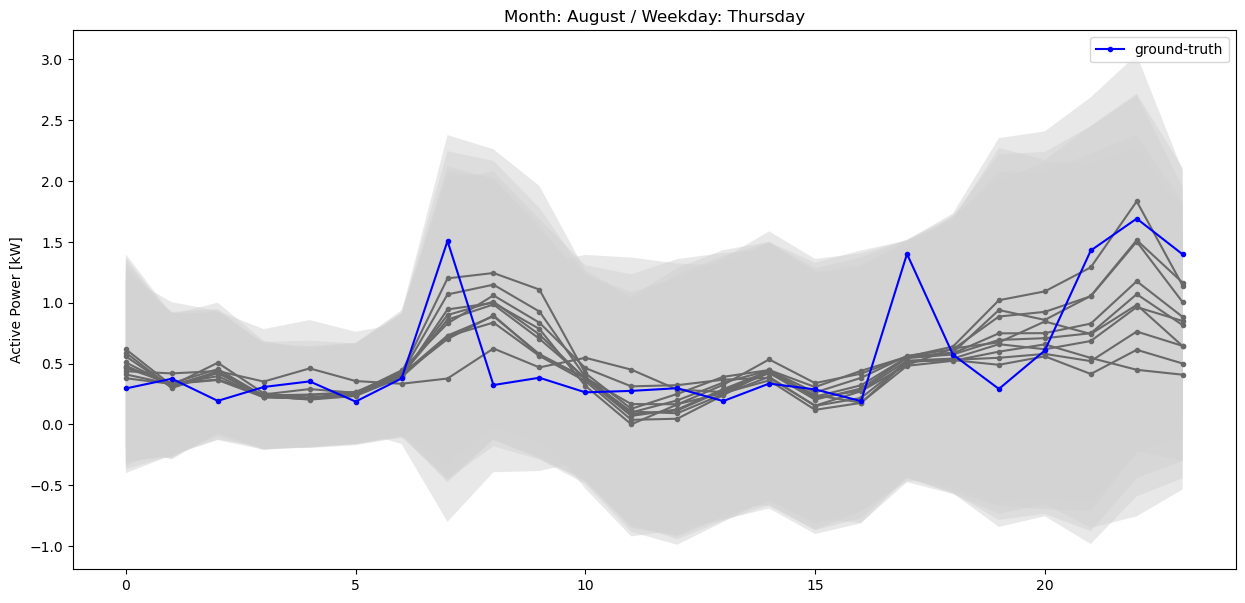

In [65]:
NUM_MC_SAMPLES = 10

import calendar
rnd_idx = torch.randint(high=dset.__len__(),size=(1,))
real_sample = dset.inputs[rnd_idx]
month = calendar.month_name[1+dset.int_conditions[rnd_idx].squeeze()[0].int().item()]
weekday = calendar.day_name[dset.int_conditions[rnd_idx].squeeze()[1].int().item()]
cond = dset.conditions[rnd_idx,[idx]]

with torch.no_grad():
    fig, ax = plt.subplots(clear=True, figsize= (15,7))
    z_mean, z_sigmatilde = model.encoder(torch.cat((real_sample,cond),dim=1))
    z_real_sample = z_mean
    ax.set_ylabel("Active Power [kW]")
    ax.set_title(f"Month: {month} / Weekday: {weekday}")
    z_samples = torch.tensor([])
    for m in range(NUM_MC_SAMPLES):
        z = model.sample(z_mean, z_sigmatilde)
        z_samples = torch.concat((z,z_samples))
        x_mean, x_sigmatilde = model.decoder(torch.cat((z,cond),dim=1))
        x_sigma = model.to_sigma(x_sigmatilde)
        x_mean = x_mean*dset.std+dset.mean
        x_sigma = x_sigma*dset.std

        ax.fill_between(list(range(feature_dim)),(x_mean+x_sigma).squeeze().numpy(), (x_mean-x_sigma).squeeze().numpy(), facecolor='lightgrey', alpha=0.5)
        ax.plot(x_mean.squeeze().numpy(), color='dimgrey', marker='.')
    ax.plot((real_sample.squeeze()*dset.std+dset.mean).numpy(), color='b', marker='.', label='ground-truth')
    ax.legend()

## Latent Visualization

We can also visualize the latent space. We approach this visualization task as showing a mixture of latent embeddings of the whole dataset, i.e. $\sum_i q_\phi(z|x_i)$. For `LATENT_DIM=2`, it is pretty straightforward. For higher dimensions, we can (naively) implement principal component analysis (PCA) for reducing the dimensions to two.

In [66]:
with torch.no_grad():
    x_dict, z_dict = model.forward(dset.inputs, dset.conditions[:,idx])

z_mean = z_dict['mean']
z_sigma = model.to_sigma(z_dict['sigmatilde'])
z_Sigma = z_sigma.square().diag_embed()
angle = 0
if LATENT_DIM > 2:
    z_mean -= z_mean.mean(dim=0)
    U,S,Vh = torch.linalg.svd(z_mean,full_matrices=False)
    z_mean = (z_mean @ Vh.t())[:,:2]
    z_Sigma = (Vh.t() @ z_sigma.square().diag_embed() @ Vh)[:,:2,:2]
    z_sigma = torch.linalg.eig(z_Sigma)[0].real.sqrt()
    eig_vectors = torch.linalg.eig(z_Sigma)[1][:,:,0].real
    angle = torch.atan2(Vh[0,1],Vh[0,0]).numpy() * 180/torch.pi

    z_samples_tr = (z_samples @ Vh.t())[:,:2]
    z_real_sample_tr = (z_real_sample @ Vh.t())[:,:2]

Here, we visualize each (transformed) $q_\phi(z|x_i)$ with ellipses. The sizes of the ellipses determined by the standard deviations of $q_\phi(z|x_i)$ and orientations of them determined by the transformation matrix coming from PCA. Also, the colors indicate the corresponding month or weekday depending on the plot. Similar colors mean close months/weekdays, i.e. the color palette is continuous and circular.

The ellipse with the black border represents the embedding of the random sample chosen in the reconstruction visualization.

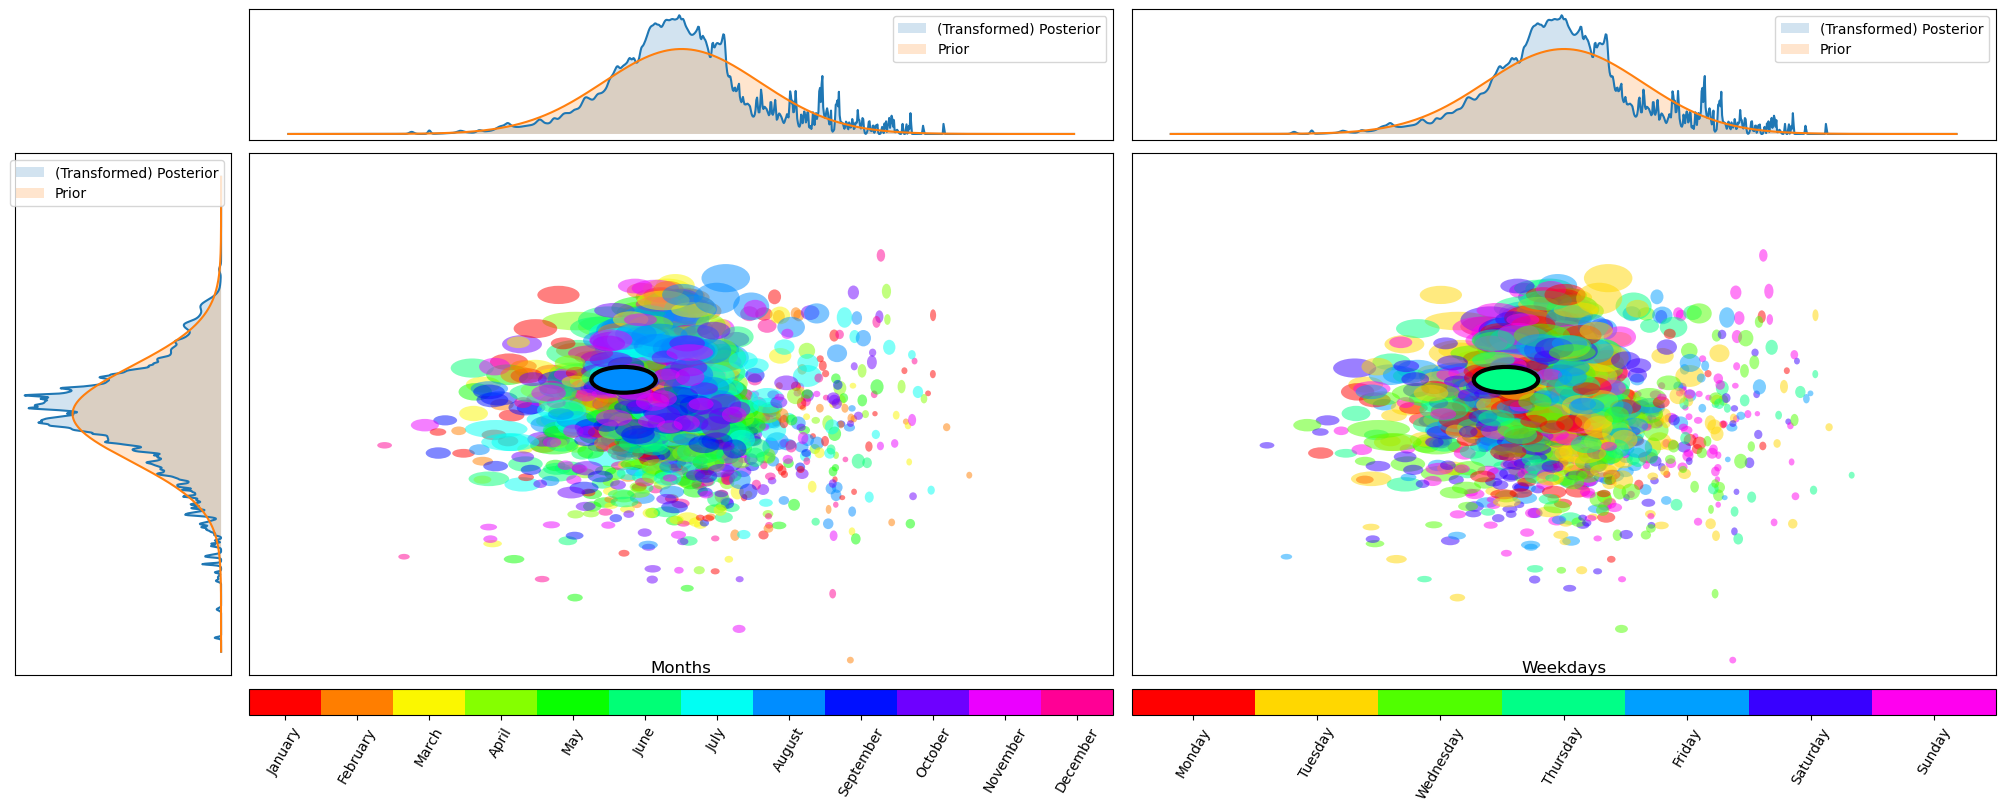

In [67]:
fig = plt.figure(figsize=(20,8) ,layout="constrained")

gs = fig.add_gridspec(3, 3, width_ratios=(1,4,4), height_ratios=(1,4,.2))

axs = [fig.add_subplot(gs[1,1]), fig.add_subplot(gs[1,2])]

month_cmap = plt.get_cmap('hsv',13)
weekday_cmap = plt.get_cmap('hsv',8)

for x,y,s1,s2, cond in zip(z_mean[:,0],z_mean[:,1],z_sigma[:,0],z_sigma[:,1], dset.int_conditions.squeeze().numpy()):
    ell = matplotlib.patches.Ellipse((x,y), s1, s2, angle=angle, alpha=.5)
    ell.set_facecolor(month_cmap(int(cond[0]-1)))
    axs[0].add_artist(ell)
    ell = matplotlib.patches.Ellipse((x,y), s1, s2, angle=angle, alpha=.5)
    ell.set_facecolor(weekday_cmap(int(cond[1])))
    axs[1].add_artist(ell)

for i, (ax, cmap) in enumerate(zip(axs,[month_cmap,weekday_cmap])):
    ell = matplotlib.patches.Ellipse((z_mean[rnd_idx,0],z_mean[rnd_idx,1]), z_sigma[rnd_idx,0], z_sigma[rnd_idx,1], angle=angle, alpha=1, lw=3)
    ell.set_edgecolor('k')
    ell.set_facecolor(cmap(dset.int_conditions[rnd_idx].squeeze()[i].int().item()))
    sct = ax.add_artist(ell)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xticks([])
    ax.set_yticks([])

axs[0].set_title("Months", y=-0.01)
axs[1].set_title("Weekdays", y=-0.01)

axs_clr = [fig.add_subplot(gs[2,1]), fig.add_subplot(gs[2,2])]

cb_months = matplotlib.colorbar.ColorbarBase(axs_clr[0], orientation='horizontal', cmap=month_cmap, boundaries=[(1.0*i)/13 for i in range(13)])
cb_months.set_ticks([(1.0*i+.5)/13 for i in range(12)])
cb_months.set_ticklabels(calendar.month_name[1:], rotation=60)
cb_weekday = matplotlib.colorbar.ColorbarBase(axs_clr[1], orientation='horizontal', cmap=weekday_cmap, boundaries=[(1.0*i)/8 for i in range(8)])
cb_weekday.set_ticks([(1.0*i+.5)/8 for i in range(7)])
cb_weekday.set_ticklabels(calendar.day_name[:], rotation=60)

axs_kde = [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,2])]

def gauss1d(x,mu,sigma):
    return (2*torch.pi*sigma**2)**(-1/2) * torch.exp(-.5 * (x-mu)**2/sigma**2)

def kde(x,Mu,Sigma):
    return 1/torch.tensor(Mu.shape[0]) * torch.sum(gauss1d(x,Mu,Sigma), dim=0)

z_ax = torch.arange(-5,5,0.01)

for i, ax in enumerate(axs_kde):
    ax.set_xticks([])
    ax.set_yticks([])

axs_kde[0].plot(kde(z_ax,z_mean[:,1].unsqueeze(-1),z_Sigma[:,1,1].unsqueeze(-1)),z_ax)
pstr1 = axs_kde[0].fill_between(kde(z_ax,z_mean[:,1].unsqueeze(-1),z_Sigma[:,1,1].unsqueeze(-1)),z_ax,alpha=0.2,label='(Transformed) Posterior')
axs_kde[0].plot(gauss1d(z_ax,0.0,1.0),z_ax)
pr1 = axs_kde[0].fill_between(gauss1d(z_ax,0.0,1.0),z_ax,alpha=0.2,label='Prior')
axs_kde[0].invert_xaxis()
axs_kde[0].legend(loc='best')

for i in range(1,3):
    axs_kde[i].plot(z_ax,kde(z_ax,z_mean[:,0].unsqueeze(-1),z_Sigma[:,0,0].unsqueeze(-1)))
    pstr = axs_kde[i].fill_between(z_ax,kde(z_ax,z_mean[:,0].unsqueeze(-1),z_Sigma[:,0,0].unsqueeze(-1)),alpha=0.2,label='(Transformed) Posterior')
    axs_kde[i].plot(z_ax,gauss1d(z_ax,0.0,1.0))
    pr = axs_kde[i].fill_between(z_ax,gauss1d(z_ax,0.0,1.0),alpha=0.2,label='Prior')
    axs_kde[i].legend(loc='best')


plt.show()
